## Goals

In this notebook, we will try another neural network architecture: EfficientNet

In [1]:
import tensorflow as tf
from tensorflow import keras
import random
import os
import matplotlib.pyplot as plt

# Dataset

In [2]:
train_folder = 'train_images' # filepath on local machine
test_folder = 'test_images' # filepath on local machine
img_height, img_width = 224, 224 # size of images
num_classes = 10 # 10 signs


batch_size = 32

AUTOTUNE = tf.data.AUTOTUNE

In [3]:
# Training and validation sets
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_folder,
    seed=42,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

# test set
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_folder,
    image_size=(img_height, img_width),
    label_mode = 'categorical',
    shuffle=False
)


Found 108 files belonging to 10 classes.
Found 30 files belonging to 10 classes.


In [4]:
# check the label names of our dataset
train_ds.class_names

['Hey',
 'How are you',
 'Name',
 'Nice to meet you',
 'No',
 'Run',
 'Sit',
 'Swim',
 'What',
 'Yes']

## Model

We will build a transafer learning model using keras functional API. 

This time we will add image augmentation to see whether performance will increase

In [5]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
], name="data_augmentation")

In [6]:
# setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images -> only happens during training
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_ds.class_names), activation="softmax", name="output_layer")(x) # same number output as classes
model = tf.keras.Model(inputs, outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainabl

In [8]:
# Compile
model.compile(loss='categorical_crossentropy',
optimizer=tf.keras.optimizers.Adam(),
metrics=['accuracy'])

# Fit
history = model.fit(train_ds,
epochs=200,
validation_data=test_ds)


Epoch 1/200
4/4 [==============================] - 14s 556ms/step - loss: 2.4794 - accuracy: 0.0926 - val_loss: 2.2818 - val_accuracy: 0.1333
Epoch 2/200
4/4 [==============================] - 1s 167ms/step - loss: 2.0511 - accuracy: 0.3333 - val_loss: 2.3102 - val_accuracy: 0.1000
Epoch 3/200
4/4 [==============================] - 1s 159ms/step - loss: 1.9922 - accuracy: 0.3889 - val_loss: 2.3373 - val_accuracy: 0.1333
Epoch 4/200
4/4 [==============================] - 1s 158ms/step - loss: 1.8736 - accuracy: 0.4167 - val_loss: 2.3054 - val_accuracy: 0.1667
Epoch 5/200
4/4 [==============================] - 1s 162ms/step - loss: 1.7849 - accuracy: 0.4352 - val_loss: 2.1818 - val_accuracy: 0.1667
Epoch 6/200
4/4 [==============================] - 1s 165ms/step - loss: 1.6948 - accuracy: 0.4722 - val_loss: 2.0661 - val_accuracy: 0.1667
Epoch 7/200
4/4 [==============================] - 1s 157ms/step - loss: 1.5947 - accuracy: 0.5370 - val_loss: 1.9786 - val_accuracy: 0.2000
Epoch 8/200


In [9]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_ds)
results_feature_extraction_model


1/1 [==============================] - 0s 97ms/step - loss: 0.6908 - accuracy: 0.8000


[0.690762460231781, 0.800000011920929]

## Visualization

We will visualize our results in train and test dataset overtime

In [10]:
def visualize(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('EfficientNet model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

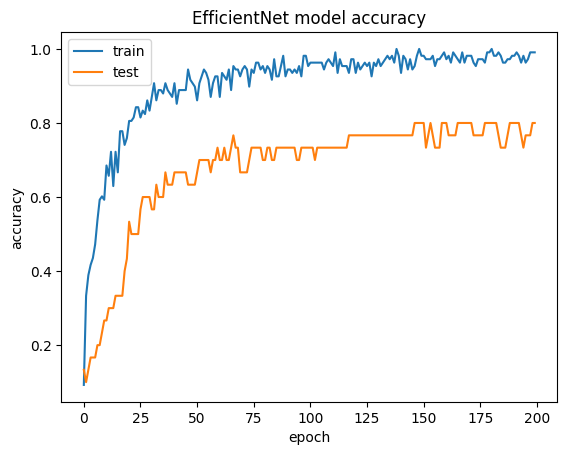

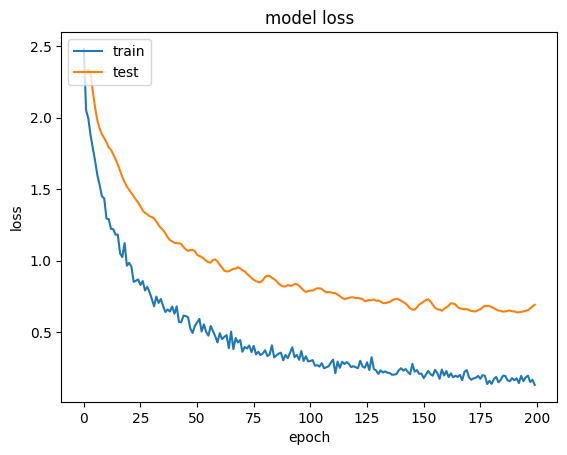

In [11]:
visualize(history)

## Predict and visualize results

In [22]:
def load_img(filename, img_shape=224, scale=True):
    """Read in an image
        Return:
        image to tensor and reshape to 250,250,3
    """
    
    # read in image
    img = tf.io.read_file(filename)
    # decode it into a tensor
    img = tf.io.decode_image(img)
    # resize the img
    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        # rescale the image (all values between 0 and 1)
        return img/255.
    else:
        return img

def predict(dataset, model):
    plt.figure(figsize=(17,10))
    for i in range(3):
        # choose a random img from a random class
        class_name = random.choice(dataset.class_names)
        filename = random.choice(os.listdir('test_images/' + class_name))
        filepath = 'test_images/' + class_name + '/' + filename

        # load the image and make prediction
        img = load_img(filepath, scale=False)
        pred_prob = model.predict(tf.expand_dims(img, axis=0)) ## model accepts tensors of shape [None, shape, shape,3]]
        pred_class = dataset.class_names[pred_prob.argmax()] # find the indices of highest prob

        # plot the img
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class:
            title_color = 'g'
        else:
            title_color = 'r'
        plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False)
    plt.show()


def n_predict(dataset, model):
    for i in range(10):
        predict(dataset, model)

1/1 [==============================] - 0s 24ms/step


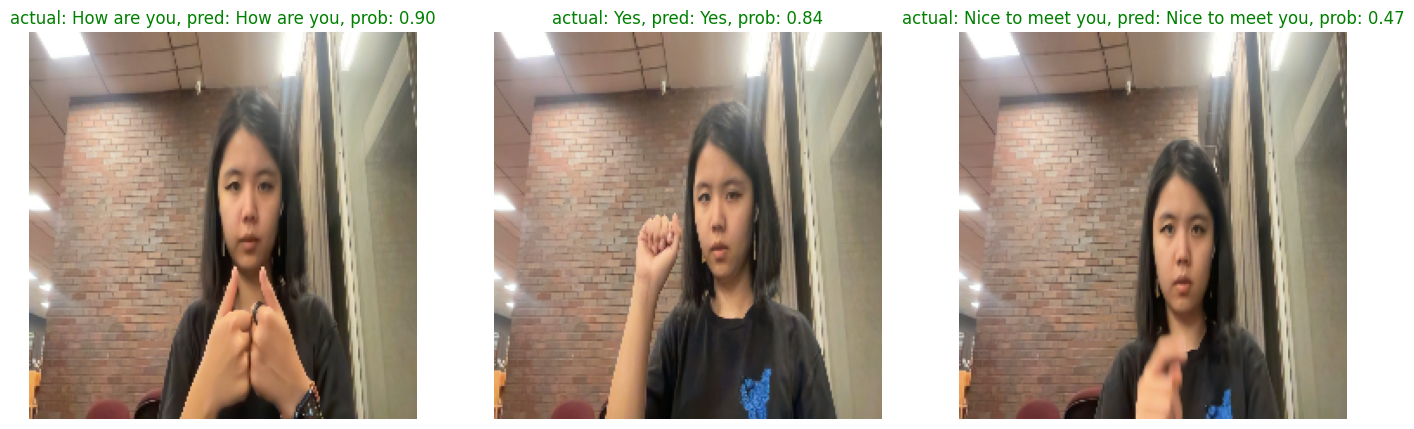

1/1 [==============================] - 0s 22ms/step


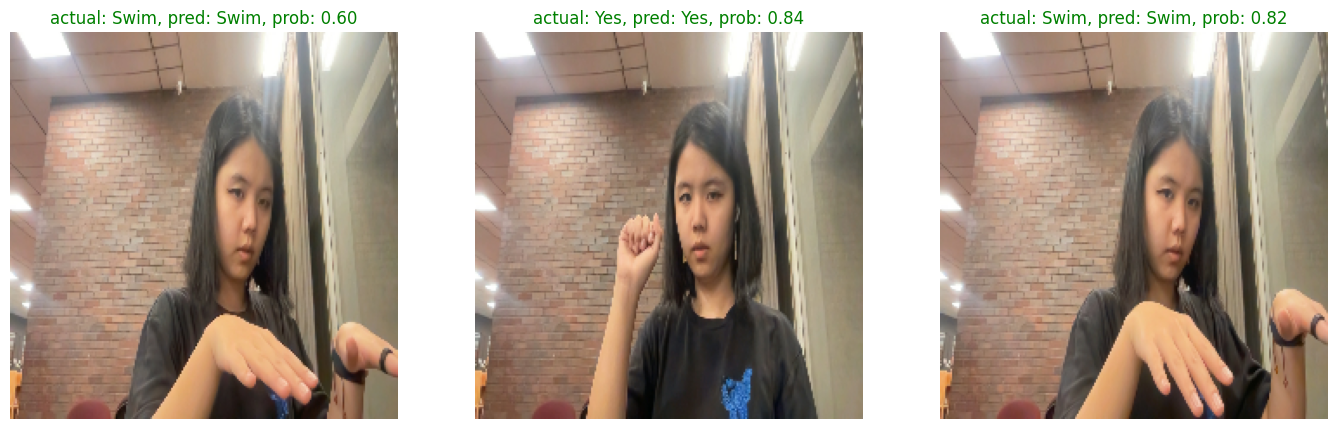

1/1 [==============================] - 0s 21ms/step


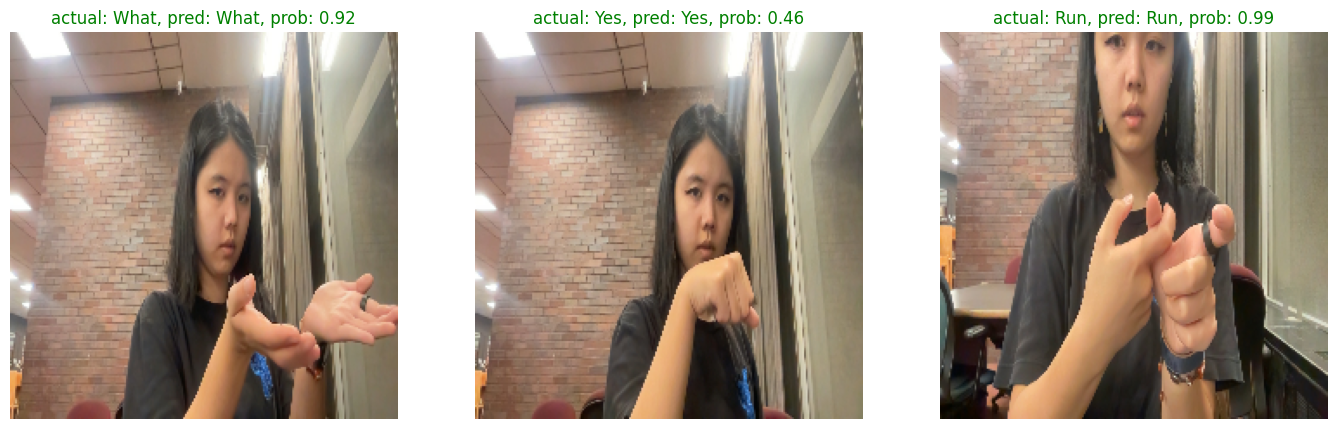

1/1 [==============================] - 0s 21ms/step


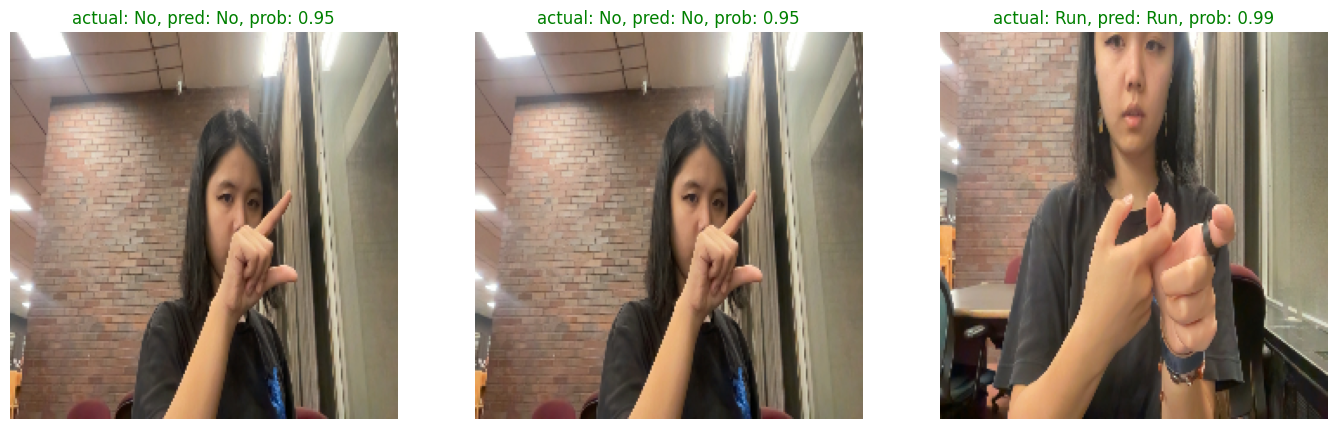

1/1 [==============================] - 0s 19ms/step


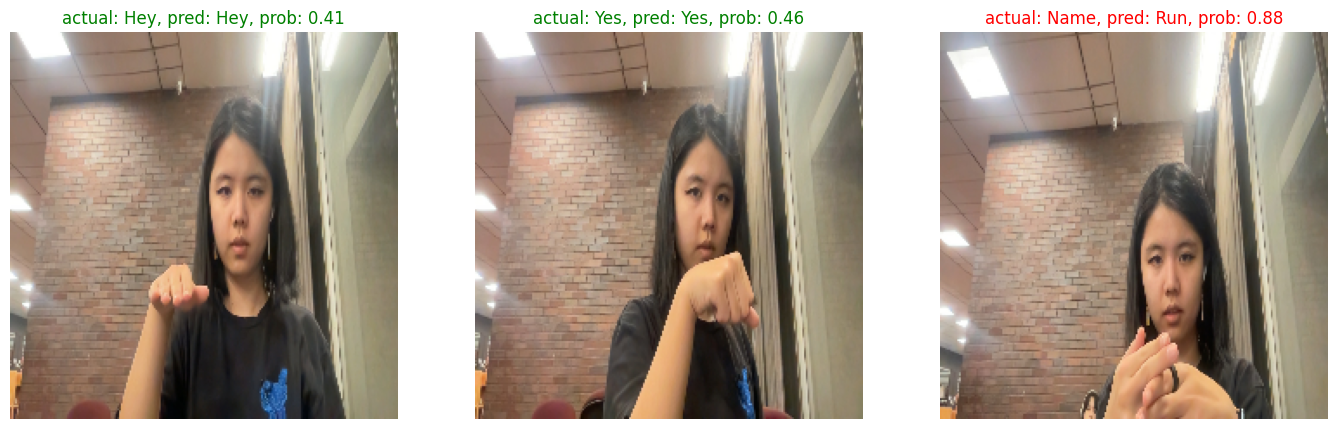

1/1 [==============================] - 0s 27ms/step


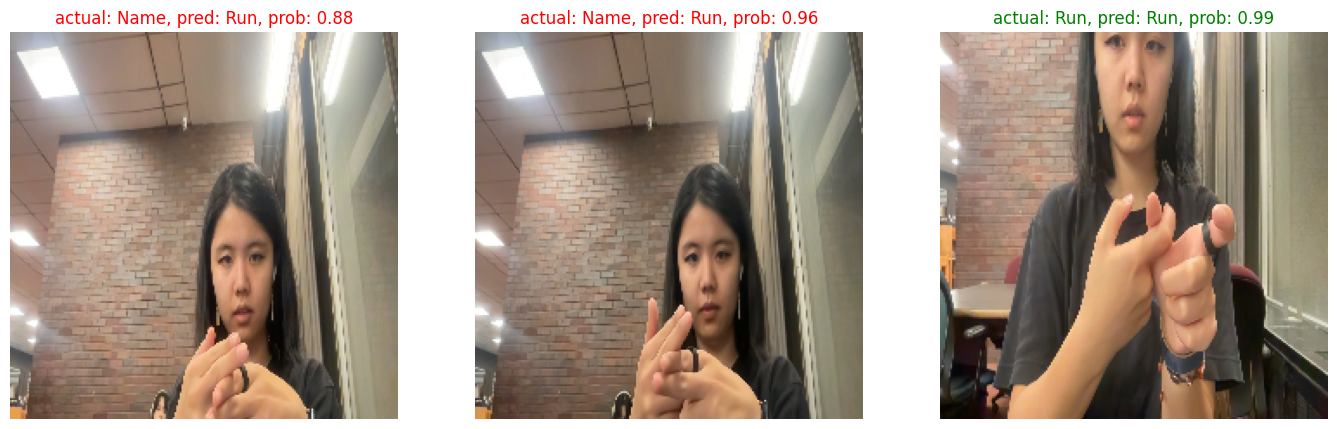

1/1 [==============================] - 0s 20ms/step


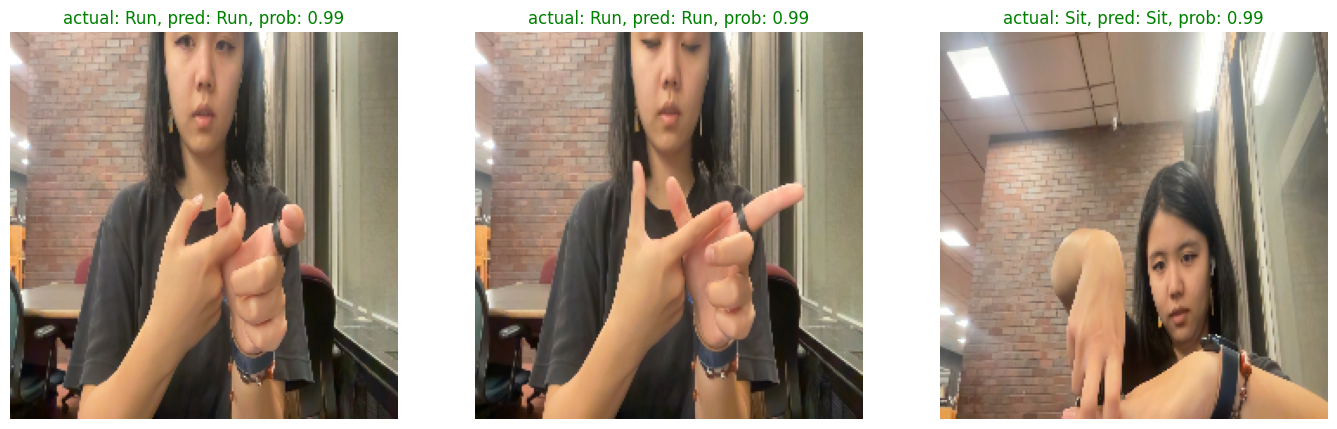

1/1 [==============================] - 0s 19ms/step


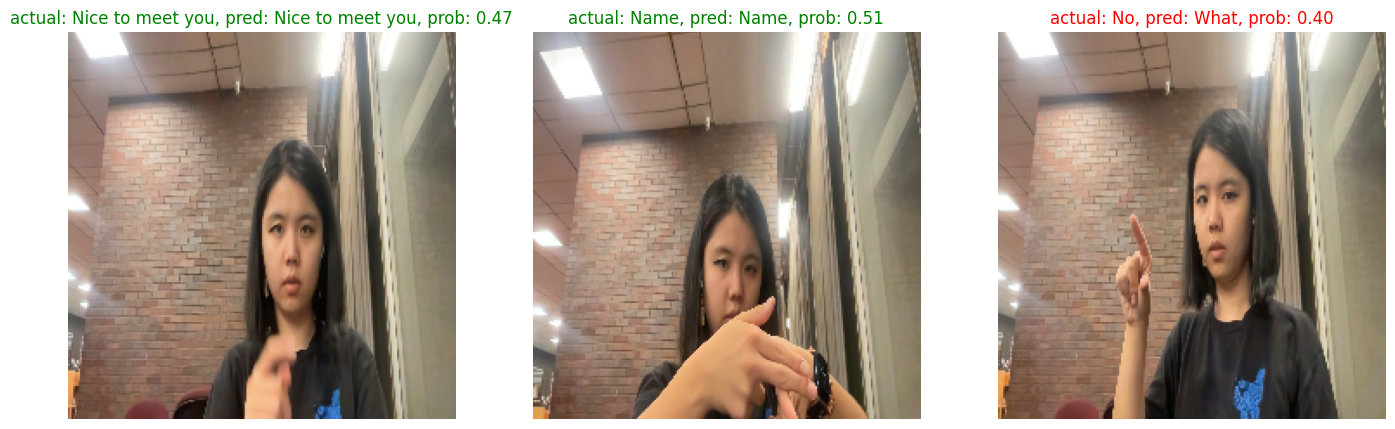

1/1 [==============================] - 0s 21ms/step


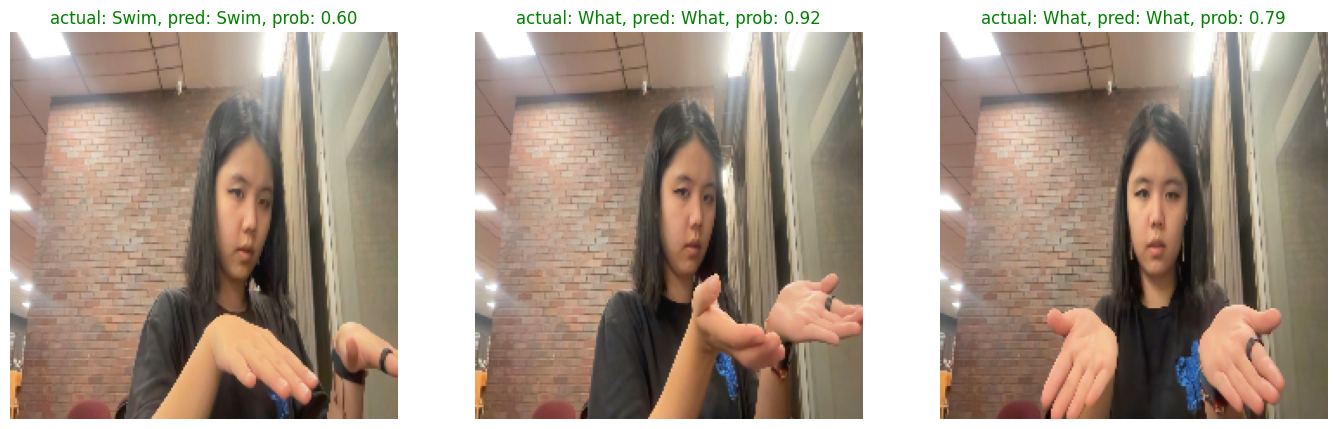

1/1 [==============================] - 0s 21ms/step


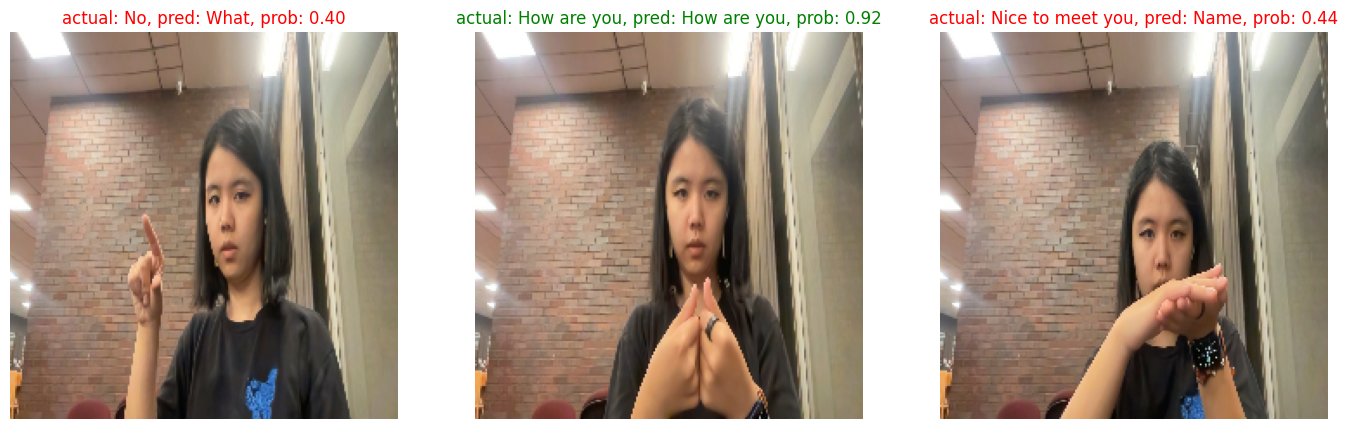

In [23]:
n_predict(test_ds, model)